In [54]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from catboost import CatBoostClassifier, Pool
import shap
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from feature_mapping import *
from sklearn.preprocessing import StandardScaler


In [3]:
df_5 = pd.read_spss('../data/caspian-5.sav',convert_categoricals=True)

In [4]:
from feature_mapping import map_feature, map_feature_4

# Step 1: Filter the dataset to keep only the features in the dictionary
features_to_keep = map_feature.keys()
df_5_filtered = df_5[list(features_to_keep)]

# Step 2: Rename the features based on the map_feature dictionary
df_5_filtered = df_5_filtered.rename(columns=map_feature)

# Step 3: Display the filtered and renamed dataset
print(df_5_filtered.head())


  university         grade gender  birth_date close_friend_count  \
0     tabriz     elemantry   girl        82.0             2 dost   
1      fasad  intermidiate   girl        81.0             1 dost   
2    ardebil     elemantry    boy        80.0          3 or more   
3   lorestan     elemantry    boy        80.0          3 or more   
4  kurdestan  intermidiate    boy        79.0          3 or more   

  spent_time_friend1 spent_time_friend2 chatting_online   body_image  \
0              0 roz              0 roz           never       normal   
1              0 roz              0 roz           never  kami laghar   
2              3 roz              4 roz  5 or 6 in week       normal   
3              0 roz              0 roz           never       normal   
4              2 roz              1 roz           never       normal   

  diet_plan  ... reduce_fat use_liquid_oil increase_vegetables reduce_sugar  \
0      khub  ...         no             no                 yes          yes   


change ap_17 to ap_21 as livingparent and remove them

In [5]:
def determine_livingparent(row):
    if row["ap_17"] == "yes" and row["ap_18"] == "yes":
        return "Ba hardo"
    elif row["ap_17"] == "yes" or row["ap_18"] == "yes":
        return "Ba yeki az valedayn"
    else:
        return "Napedar v na madar"

df_5_filtered["livingparent"] = df_5_filtered.apply(determine_livingparent, axis=1)
df_5_filtered.drop(['ap_17','ap_18','ap_19','ap_20','ap_21'],axis=1,inplace=True)
df_5_filtered['source']='casp 5'

In [6]:
df_5_filtered.shape

(13983, 128)

upload dataset 4

In [7]:
from feature_mapping import map_feature_4
df_4 = pd.read_spss('../final_data/caspian4-ghorbani.sav')
features_to_keep = map_feature_4.keys()
df_4_filtered = df_4[list(features_to_keep)]

df_4_filtered = df_4_filtered.rename(columns=map_feature_4)
df_4_filtered['source']='casp 4'
# Step 4: Display the filtered dataset
print(df_4_filtered.head())

        university      grade gender  birth_date close_friend_count  \
0  khozestan-ahvaz  rahnamayi    boy        79.0               yeki   
1  khozestan-ahvaz  rahnamayi    boy        74.0     3ta va bishtar   
2          boshehr   ebtedayi   girl        80.0     3ta va bishtar   
3          ardabil  rahnamayi   girl        78.0                2ta   
4          ardabil   ebtedayi   girl        81.0               yeki   

  spent_time_friend1 spent_time_friend2       chatting_online body_image  \
0           hich ruz               3ruz  5 ya 6 ruz dar hafte  kami chag   
1               2ruz               2ruz   1 ya 2ruz dar hafte     normal   
2           hich ruz               2ruz  5 ya 6 ruz dar hafte  kamilagar   
3               5ruz               4ruz  3 ya 4 ruz dar hafte  kamilagar   
4               1ruz               1ruz   1 ya 2ruz dar hafte     normal   

      diet_plan  ... reduce_fast_food increase_vegetables reduce_salt  \
0  no wt ok ast  ...               no      

In [8]:
combined_df = pd.concat([df_4_filtered, df_5_filtered], ignore_index=True)

# Display the combined dataset
combined_df.columns

Index(['university', 'grade', 'gender', 'birth_date', 'close_friend_count',
       'spent_time_friend1', 'spent_time_friend2', 'chatting_online',
       'body_image', 'diet_plan',
       ...
       'reduce_fast_food', 'increase_vegetables', 'reduce_salt',
       'reduce_sugar', 'reduce_fat', 'use_liquid_oil', 'injury_parent_ask',
       'injury_complication', 'region', 'source'],
      dtype='object', length=128)

In [9]:
import re
combined_df.replace('', np.nan, inplace=True)
combined_df.replace('rarely','seldom/never',inplace=True)
combined_df.replace('never','seldom/never',inplace=True)

combined_df.replace('hichvaght','seldom/never',inplace=True)
combined_df.replace({'hich ruz': '0 day', 'hich ruzi': '0 day'}, inplace=True)

categorical_columns = combined_df.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    combined_df[col] = combined_df[col].apply(lambda x: x.lower() if isinstance(x, str) and x != '' else np.nan)
    combined_df[col] = combined_df[col].apply(lambda x: x.strip() if isinstance(x, str) and x != '' else np.nan)
    combined_df[col] = combined_df[col].apply(lambda x: re.sub(r'(\d)(\w)', r'\1 \2', str(x)) if isinstance(x, str) else x)
    combined_df[col] = combined_df[col].apply(lambda x: str(x).replace('ruzi', 'day').replace('ruz', 'day').replace('roz', 'day') if isinstance(x, str) else x)
    combined_df[col] = combined_df[col].apply(lambda x: str(x).replace('hours', 'hour').replace('saat', 'hour') if isinstance(x, str) else x)
    combined_df[col] = combined_df[col].apply(lambda x: re.sub(r'(\d)\s*ta\s*(\d)', r'\1-\2', str(x)) if isinstance(x, str) else x)
    

In [10]:
# Standardize column names
df_4_filtered.columns = df_4_filtered.columns.str.strip().str.lower()
df_5_filtered.columns = df_5_filtered.columns.str.strip().str.lower()

# Compare again
print("Columns in df1 but not in df2:", set(df_4_filtered.columns) - set(df_5_filtered.columns))
print("Columns in df2 but not in df1:", set(df_5_filtered.columns) - set(df_4_filtered.columns))


Columns in df1 but not in df2: set()
Columns in df2 but not in df1: set()


In [11]:
categorical_columns = combined_df.select_dtypes(include=['object', 'category']).columns

# Get unique values for each categorical column
unique_values = {col: combined_df[col].dropna().unique().tolist() for col in categorical_columns}

# Print the results
for col, values in unique_values.items():
    print(f"Column: {col}, Unique Values: {values}")

Column: university, Unique Values: ['khozestan-ahvaz', 'boshehr', 'ardabil', 'azar garbi', 'khorasan shomali-bojnord', 'qazvin', 'lorestan', 'khorasan razavi-mashad', 'kordestan', 'yazd', 'kerman-kerman', 'kermanshah', 'isfahan', 'markazi', 'shahid beheshti', 'sistan-zabol', 'ilam', 'kohkiloye', '4 mahal bakhtiyari', 'hormzgan', 'sistan-zahedan', 'semnan-semnan', 'golestan', 'mazandaran-babol', 'kerman-jiroft', 'hamadan', 'semnan-shahrod', 'khozestan-dezfol', 'alborz', 'kerman-rafsanjan', 'azar shargi', 'zanjan', 'fars-shiraz', 'gilan', 'qom', 'fars-jahrom', 'isfahan-kashan', 'tehran', 'khorasan razavi-sabzavar', 'khorasan razavi-neishabor', 'fars-fasa', 'tabriz', 'fasad', 'ardebil', 'kurdestan', 'khorasan shomali', 'charmahal', 'khorasan jonobi', 'azar gharbi', 'mazandaran', 'kohkiloyeh', 'babol', 'rafsanjan', 'zabol', 'hormozgan', 'arak', 'khozestan', 'kerman', 'semnan', 'hamedan', 'behbahan', 'kerman.jiroft', 'khorasan razavi', 'esfarayen', 'iran', 'saveh', 'dezful', 'neishabor', 'a

In [12]:
from feature_mapping import mapping_university
combined_df['university'] = combined_df['university'].apply(lambda x: mapping_university.get(x, x))

In [13]:
from feature_mapping import mapping_grade
combined_df['grade'] = combined_df['grade'].apply(lambda x: mapping_grade.get(x, x))

In [14]:
from feature_mapping import mapping_close_friend_count
combined_df['close_friend_count'] = combined_df['close_friend_count'].apply(lambda x: mapping_close_friend_count.get(x, x))

In [15]:
from feature_mapping import mapping_chatting_online
combined_df['chatting_online'] = combined_df['chatting_online'].apply(lambda x: mapping_chatting_online.get(x, x))

In [16]:
from feature_mapping import mapping_body_img
combined_df['body_image'] = combined_df['body_image'].apply(lambda x: mapping_body_img.get(x, x))

In [17]:
from feature_mapping import mapping_diet_plan
combined_df['diet_plan'] = combined_df['diet_plan'].apply(lambda x: mapping_diet_plan.get(x, x))

In [18]:
from feature_mapping import mapping_breakfast_routindays
combined_df['breakfast_routindays'] = combined_df['breakfast_routindays'].apply(lambda x: mapping_breakfast_routindays.get(x, x))

In [19]:
from feature_mapping import mapping_breakfast_friday
combined_df['breakfast_friday'] = combined_df['breakfast_friday'].apply(lambda x: mapping_breakfast_friday.get(x, x))

In [20]:
from feature_mapping import mapping_lunch_routindays,mapping_lunch_friday,mapping_dinner_routindays
combined_df['lunch_routinday'] = combined_df['lunch_routinday'].apply(lambda x: mapping_lunch_routindays.get(x, x))
combined_df['lunch_friday'] = combined_df['lunch_friday'].apply(lambda x: mapping_lunch_friday.get(x, x))
combined_df['dinner_routinday'] = combined_df['dinner_routinday'].apply(lambda x: mapping_dinner_routindays.get(x, x))
combined_df['dinner_friday'] = combined_df['dinner_friday'].apply(lambda x: mapping_lunch_friday.get(x, x))


In [21]:
from feature_mapping import mapping_screen_timing
combined_df['TV_watching_routinday'] = combined_df['TV_watching_routinday'].apply(lambda x: mapping_screen_timing.get(x, x))
combined_df['TV_watching_friday'] = combined_df['TV_watching_friday'].apply(lambda x: mapping_screen_timing.get(x, x))
combined_df['computer_work_routinday'] = combined_df['computer_work_routinday'].apply(lambda x: mapping_screen_timing.get(x, x))
combined_df['computer_work_friday'] = combined_df['computer_work_friday'].apply(lambda x: mapping_screen_timing.get(x, x))

In [22]:
from feature_mapping import (
    mapping_injury_times,
    mapping_injury_place,
    mapping_injury_treatment_place,
    mapping_fight_number,
    mappling_litigant,
    mapping_carry_weapons,
    mapping_victim_number,
    mapping_bully_number,
)
from feature_mapping import mapping_injury_cause

combined_df["injury_number"] = combined_df["injury_number"].apply(
    lambda x: mapping_injury_times.get(x, x)
)
combined_df["injury_place"] = combined_df["injury_place"].apply(
    lambda x: mapping_injury_place.get(x, x)
)
combined_df["injury_cause"] = combined_df["injury_cause"].apply(
    lambda x: mapping_injury_cause.get(x, x)
)
combined_df["injury_treatment_place"] = combined_df["injury_treatment_place"].apply(
    lambda x: mapping_injury_treatment_place.get(x, x)
)
combined_df["fight_number"] = combined_df["fight_number"].apply(
    lambda x: mapping_fight_number.get(x, x)
)
combined_df["litigant"] = combined_df["litigant"].apply(
    lambda x: mappling_litigant.get(x, x)
)
combined_df["carry_weapons"] = combined_df["carry_weapons"].apply(
    lambda x: mapping_carry_weapons.get(x, x)
)
combined_df["victim_number"] = combined_df["victim_number"].apply(
    lambda x: mapping_victim_number.get(x, x)
)
combined_df["bully_number"] = combined_df["bully_number"].apply(
    lambda x: mapping_bully_number.get(x, x)
)


In [23]:
from feature_mapping import mapping_feeling_number

feeling = [
    "confusion_number",
    "worthless_number",
    "insomnia_number",
    "back_pain_number",
    "headache_number",
    "worried_number",
    "stomach_ache_number",
    "angriness_number",
]
for col in feeling:
    combined_df[col] = combined_df[col].apply(
        lambda x: mapping_feeling_number.get(x, x)
    )

In [24]:
from feature_mapping import mapping_depression
combined_df['depression']=combined_df['depression'].apply(lambda x: mapping_depression.get(x,x))

In [25]:
from feature_mapping import mapping_anxiety
combined_df['anxiety_number']=combined_df['anxiety_number'].apply(lambda x: mapping_anxiety.get(x,x))

In [26]:
from feature_mapping import mappingـmental_health
combined_df['mental_health_overview']=combined_df['mental_health_overview'].apply(lambda x: mappingـmental_health.get(x,x))

In [27]:
from feature_mapping import mapping_catage
combined_df = combined_df[(combined_df['age'] >= 7) & (combined_df['age'] <= 18)]
combined_df['catage']=combined_df['catage'].apply(lambda x: mapping_catage.get(x,x))
combined_df['catage'].value_counts()


11-14    10141
7-10      9082
15-18     7959
Name: catage, dtype: int64

In [28]:
from feature_mapping import mapping_smoking_type
combined_df['smoking_type']=combined_df['smoking_type'].apply(lambda x: mapping_smoking_type.get(x,x))

In [29]:
from feature_mapping import mapping_home_ownership
combined_df['home_ownership']=combined_df['home_ownership'].apply(lambda x: mapping_home_ownership.get(x,x))

In [30]:
from feature_mapping import mapping_edu
combined_df['father_edu']=combined_df['father_edu'].apply(lambda x: mapping_edu.get(x,x))
combined_df['mother_edu']=combined_df['mother_edu'].apply(lambda x: mapping_edu.get(x,x))


In [31]:
from feature_mapping import (
    father_job_mapping,
    mother_job_mapping,
    school_type_mapping,
    birth_weight_mapping,
    milk_type_mapping,
    complementary_feeding_mapping,
)

combined_df["father_job"] = combined_df["father_job"].apply(
    lambda x: father_job_mapping.get(x, x)
)
combined_df["mother_job"] = combined_df["mother_job"].apply(
    lambda x: mother_job_mapping.get(x, x)
)
combined_df["school_type"] = combined_df["school_type"].apply(
    lambda x: school_type_mapping.get(x, x)
)
combined_df["birth_weight"] = combined_df["birth_weight"].apply(
    lambda x: birth_weight_mapping.get(x, x)
)
combined_df["milk_type"] = combined_df["milk_type"].apply(
    lambda x: milk_type_mapping.get(x, x)
)
combined_df["complementary_feeding"] = combined_df["complementary_feeding"].apply(
    lambda x: complementary_feeding_mapping.get(x, x)
)


In [32]:
combined_df['bread_type'].replace({
    'bedune sabus': 'White bread',
    'sabusdar': 'whole grain bread',
    'sabus dar': 'whole grain bread'
},inplace=True)



In [33]:
combined_df['oil_type']=combined_df['oil_type'].apply(lambda x:oil_type_mapping.get(x,x))
combined_df['table_salt']=combined_df['table_salt'].apply(lambda x:table_salt_mapping.get(x,x))
combined_df['dairy_type']=combined_df['dairy_type'].apply(lambda x:dairy_type_mapping.get(x,x))
combined_df['injury_complication']= combined_df['injury_complication'].apply(lambda x:injury_complication_mapping.get(x,x))

In [34]:
categorical_columns = combined_df.select_dtypes(include=['object', 'category']).columns
# Get unique values for each categorical column
unique_values = {col: combined_df[col].dropna().unique().tolist() for col in categorical_columns}

# Print the results
for col, values in unique_values.items():
    print(f"Column: {col}, Unique Values: {values}")

Column: university, Unique Values: ['khozestan', 'bushehr', 'ardabil', 'azar gharbi', 'khorasan shomali', 'qazvin', 'lorestan', 'khorasan razavi', 'kordestan', 'yazd', 'kerman', 'kermanshah', 'isfahan', 'markazi', 'shahid beheshti', 'ilam', 'kohgiluyeh', 'chaharmahal bakhtiyari', 'hormozgan', 'sistan', 'semnan', 'golestan', 'mazandaran', 'jiroft', 'hamedan', 'dezful', 'alborz', 'rafsanjan', 'azar sharghi', 'zanjan', 'fars', 'gilan', 'qom', 'jahrom', 'kashan', 'tehran', 'sabzevar', 'neishabor', 'fasa', 'tabriz', 'khorasan jonoubi', 'babol', 'zabol', 'arak', 'behbahan', 'esfarayen', 'iran', 'saveh', 'abadan', 'torbat jam', 'iranshahr', 'torbat heidariyeh', 'bam', 'shahrood', 'shushtar', 'larestan']
Column: grade, Unique Values: ['intermediate', 'elementary']
Column: gender, Unique Values: ['boy', 'girl']
Column: close_friend_count, Unique Values: ['one', 'three or more', 'two', 'any']
Column: spent_time_friend1, Unique Values: ['0 day', '2 day', '5 day', '1 day', '4 day', '6 day', '3 day

In [35]:
!pwd

/home/atefe_hjn97/Documents/VScode/caspian_second/casp 5


In [36]:
combined_df.to_csv('combined_data_alignment_4&5_v1.csv')

missing value handling

In [37]:
df=combined_df.copy()
df = df[df['gender']=='boy']

drop column with over 80 percent missing value

In [38]:
to_drop_col = []
for column in df.columns:
    null_percentage = df[column].isnull().mean()*100
    print(f"Column '{column}' has {null_percentage} null values.")
    if null_percentage>70:
        to_drop_col.append(column)
print(df.shape)
df=df.drop(to_drop_col,axis=1)
print(df.shape)


Column 'university' has 0.0 null values.
Column 'grade' has 0.0 null values.
Column 'gender' has 0.0 null values.
Column 'birth_date' has 0.0 null values.
Column 'close_friend_count' has 0.26103980857080705 null values.
Column 'spent_time_friend1' has 0.61634399245885 null values.
Column 'spent_time_friend2' has 0.2972953375389747 null values.
Column 'chatting_online' has 0.33355086650714233 null values.
Column 'body_image' has 0.2030309622217388 null values.
Column 'diet_plan' has 0.5365818287288812 null values.
Column 'breakfast_routindays' has 0.33355086650714233 null values.
Column 'breakfast_friday' has 1.3269523602349358 null values.
Column 'lunch_routinday' has 1.493727793488507 null values.
Column 'lunch_friday' has 49.00297295337539 null values.
Column 'dinner_routinday' has 48.669422086868245 null values.
Column 'dinner_friday' has 49.01747516496266 null values.
Column 'sweet' has 0.3480530780944094 null values.
Column 'saltysnack' has 0.6453484156333841 null values.
Column '

fill null value

In [39]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
for col in numerical_columns:
    if df[col].isna().any():  # Only process columns with missing values
        df[col] = df.groupby('age')[col].transform(
            lambda x: x.fillna(x.mean())
        )
for col in categorical_columns:
    # Fill null values with the mode of the column within each age group
    if df[col].isna().any():  # Only process columns with missing values
        df[col] = df.groupby('age')[col].transform(
            lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
        )

bmi calculation

In [40]:
df["bmi"] = df["weight"] / ((df["height"] / 100) ** 2)

/tmp/ipykernel_146257/2046101176.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["bmi"] = df["weight"] / ((df["height"] / 100) ** 2)


In [41]:
df_who_ref = pd.read_excel('../WHO_tables/bmi-boys-perc-who2007-exp.xlsx')
# Define the age range and convert it to months
age_years = list(range(7, 19))  # From 7 to 18 years inclusive
age_months = [age * 12 for age in age_years]

# Filter the dataset for the specified months and select relevant columns
who_df = df_who_ref[df_who_ref['Month'].isin(age_months)][['Month', 'P5', 'P15', 'P85', 'P95']]

# Map months back to years for clarity
who_df['Age'] = who_df['Month'] // 12
filtered_df = who_df.drop(columns=['Month'])

who_df = who_df.reset_index(drop=True)
who_df

,Month,P5,P15,P85,P95,Age
0,84,13.504,14.166,17.111,18.261,7
1,96,13.666,14.350,17.508,18.802,8
2,108,13.866,14.579,17.987,19.453,9
3,120,14.127,14.875,18.568,20.225,10
4,132,14.469,15.260,19.260,21.113,11
5,144,14.891,15.734,20.052,22.090,12
6,156,15.402,16.303,20.943,23.144,13
7,168,15.976,16.941,21.891,24.221,14
8,180,16.547,17.580,22.812,25.229,15
9,192,17.078,18.176,23.656,26.126,16


In [42]:
def calculate_percentile_labels(row, who_ref):
    """
    Categorizes BMI based on WHO reference percentiles for the corresponding age.
    """
    age = row['age']
    bmi = row['bmi']
    
    # Filter WHO reference data for the specific age
    ref_data = who_ref[who_ref['Age'] == age]
    
    if ref_data.empty:
        return 'Unknown'  # Handle cases where reference data is not available
    
    # Extract the percentiles
    p5 = ref_data['P5'].values[0]
    p85 = ref_data['P85'].values[0]
    p95 = ref_data['P95'].values[0]
    
    # Categorize based on percentiles
    if bmi < p5:
        return 'abnormal'
    elif p5 <= bmi < p85:
        return 'normal'
    elif p85 <= bmi < p95:
        return 'abnormal'
    else:
        return 'abnormal'

def calculate_percentiles(df_org, who_ref):
    """
    Adds a percentile category for each row based on WHO reference data.
    """
    df = df_org.copy()
    
    # Apply the function to calculate percentile categories
    df['bmi_category'] = df.apply(
        lambda row: calculate_percentile_labels(row, who_ref), axis=1
    )

    return df

In [43]:
# Use the WHO reference dataframe (df_who_ref)
df = calculate_percentiles(df, who_df)

df[['age','bmi','height','weight','bmi_category']].head()


,age,bmi,height,weight,bmi_category
0,12.0,30.024691,112.5,38.0,abnormal
1,17.0,22.448980,140.0,44.0,normal
5,12.0,37.591041,113.0,48.0,abnormal
6,16.0,16.760381,136.0,31.0,abnormal
7,8.0,27.448289,101.0,28.0,abnormal


/tmp/ipykernel_146257/159732643.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


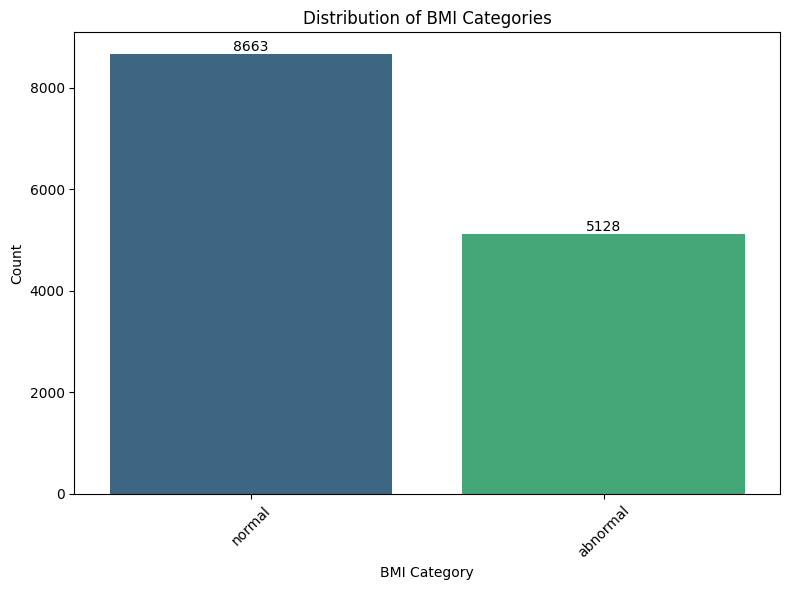

In [44]:
def plot_bmi_categories(df, feature):

        category_counts = df[f'{feature}_category'].value_counts()

        # Plot the counts
        plt.figure(figsize=(8, 6))
        ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')

        # Annotate counts above each bar
        for i, count in enumerate(category_counts.values):
            ax.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

        # Customize plot
        plt.title(f"Distribution of BMI Categories")
        plt.xlabel("BMI Category")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_bmi_categories(df,'bmi')


In [45]:
def frequency_encode(df, categorical_columns,numerical_columns, group_by_column='age'):
    """
    Applies frequency encoding to the specified columns in the dataframe, filling null values with the mode based on each age group.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        columns (list): List of categorical columns to be frequency encoded.
        group_by_column (str): The column name to group by (default is 'age').

    Returns:
        pd.DataFrame: A dataframe with frequency-encoded columns.
    """
    df_encoded = df.copy()

    for col in categorical_columns:
        # Calculate the frequency for encoding after filling missing values
        if col != 'bmi_category':
            frequency = df_encoded[col].value_counts() / len(df_encoded)
        
            # Apply frequency encoding
            df_encoded[col] = df_encoded[col].map(frequency)
        else:
             class_mapping = {'abnormal':0,'normal':1}
             df_encoded[col]=df_encoded[col].map(class_mapping)

    return df_encoded

# Example Usage
# Assuming 'df' is your dataframe
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
df_encoded = frequency_encode(df, categorical_columns,numerical_columns)


In [46]:
df['computer_ownership'].value_counts()

no     6933
yes    6858
Name: computer_ownership, dtype: int64

In [47]:
df_encoded['oil_type'].value_counts()

0.389819    5376
0.370604    5111
0.177435    2447
0.045102     622
0.013777     190
0.003263      45
Name: oil_type, dtype: int64

In [51]:
df_encoded['bmi_category'].value_counts().to_list()[-1]

5128

In [56]:
import xgboost as xgb
# Define functions
def split_X_y(df_org):
    df = df_org.copy()
    unique_counts = df['bmi_category'].value_counts().to_list()[-1]

    class_2_samples = df[df['bmi_category'] == 1]  # Filter rows where the label is 2
    other_classes = df[df['bmi_category'] != 1]   # Filter rows for other classes

    # Randomly select 700 samples from class 2
    selected_class_2 = class_2_samples.sample(n=unique_counts, random_state=42)

    # Combine the selected samples from class 2 with other classes
    balanced_df = pd.concat([selected_class_2, other_classes], ignore_index=True)

    # Reset the index of the resulting DataFrame
    balanced_df = balanced_df.reset_index(drop=True)
    X = balanced_df.drop(columns=['weight', 'bmi','hip', 'wrist', 'waist','age',
                          'catage', 'grade', 'height','body_image','bmi_category','gender','systolic','diastoli'], axis=1)
    y = balanced_df['bmi_category']
    print('X: ',X.shape)
    print('y: ',y.shape)

    return X, y
def standardize_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data and transform
    X_test_scaled = scaler.transform(X_test)        # Only transform test data
    return X_train_scaled, X_test_scaled

def select_features(X, y, method, k=50, active=False):
    if active:
        selector = SelectKBest(method, k=k)
        selector.fit(X, y)
        return X.columns[selector.get_support()].tolist()
    else:
        return X.columns.tolist()

def train_catboost(X_train, y_train, iterations=200, random_state=42, learning_rate=0.1, depth=10, l2_leaf_reg=3, bagging_temperature=1):
    model = CatBoostClassifier(
        iterations=iterations, 
        random_seed=random_state, 
        verbose=0, 
        learning_rate=learning_rate, 
        depth=depth, 
        l2_leaf_reg=l2_leaf_reg, 
        bagging_temperature=bagging_temperature
    )
    model.fit(X_train, y_train)
    return model, iterations

def train_xgboost(X_train, y_train, iterations=300, random_state=42, learning_rate=0.1, max_depth=20, reg_lambda=1, subsample=1):
    model = xgb.XGBClassifier(
        n_estimators=iterations,  # Corresponds to iterations in CatBoost
        random_state=random_state,
        learning_rate=learning_rate,
        max_depth=max_depth,
        reg_lambda=reg_lambda,  # L2 regularization
        subsample=subsample  # Corresponds to bagging_temperature in CatBoost
    )
    model.fit(X_train, y_train)
    return model, iterations

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    print("accuracy", accuracy)
    print("report", report)
    return {"accuracy": accuracy, "report": report}

def process_and_train_model_for_each_age(df, catage, k=20):
    results = []
    shap_values = None  
    X_train_selected = None  

    for cat in catage:
        df_age = df[np.abs(df['catage'] - cat) < 1e-6]
        if df_age.empty:
            continue
        X, y = split_X_y(df_age)
        resampling_pipeline = Pipeline([
            ('smote', SMOTE(random_state=42)),
            ('undersampler', RandomUnderSampler(random_state=42))
        ])
        
        # Resample the dataset
        # X_resampled, y_resampled = resampling_pipeline.fit_resample(X, y)
        X_resampled = X
        y_resampled = y
        print(f"Original class distribution:\n{y.value_counts()}")
        print(f"\nResampled class distribution:\n{y_resampled.value_counts()}")

        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)
        X_train_scaled, X_test_scaled = standardize_data(X_train, X_test)
        
        catboost_model, iterations = train_catboost(X_train_scaled, y_train)
        catboost_metrics = evaluate_model(catboost_model, X_test_scaled, y_test)
        class_labels = catboost_model.classes_
        # Calculate feature importance
        # feature_importance = catboost_model.get_feature_importance(prettified=False)
        # explainer = shap.TreeExplainer(catboost_model)
        # shap_values = explainer.shap_values(X)  # Compute SHAP values

        # num_classes = shap_values.shape[-1]  # Number of classes (last dimension of SHAP values)
        # for class_index in range(num_classes):
        #     print(f"Generating SHAP summary plot for class {class_labels[class_index]}")
            
        #     # Extract SHAP values for this class
        #     class_shap_values = shap_values[:, :, class_index]  # Shape: (4044, 343)
        #     # Plot SHAP summary for the selected class
        #     shap.summary_plot(class_shap_values, X, show=False)
        #     plt.title(f"SHAP Summary for Class {class_labels[class_index]}")
        #     plt.show()

        # Append results
        results.append({
            "catage": cat,
            "accuracy": catboost_metrics['accuracy'],
            "num_samples": len(df_age),
            "classification_report": catboost_metrics['report']
            # ,"top_features": ", ".join(top_features)
        })

    return results, shap_values, X_train_selected

# Plot BMI category distribution
catage = df_encoded['catage'].unique()
results, shap_values, X_train_selected = process_and_train_model_for_each_age(df_encoded, catage)

results_df = pd.DataFrame([{
    "catage": r["catage"],
    "accuracy": r["accuracy"],
    "num_samples": r["num_samples"],
    # "top_features": r["top_features"],
    "classification_report": r["classification_report"]
} for r in results])

X:  (4078, 111)
y:  (4078,)
Original class distribution:
1    2039
0    2039
Name: bmi_category, dtype: int64

Resampled class distribution:
1    2039
0    2039
Name: bmi_category, dtype: int64
accuracy 0.5526960784313726
report {'0': {'precision': 0.5570291777188329, 'recall': 0.5147058823529411, 'f1-score': 0.535031847133758, 'support': 408.0}, '1': {'precision': 0.5489749430523918, 'recall': 0.5906862745098039, 'f1-score': 0.5690672963400236, 'support': 408.0}, 'accuracy': 0.5526960784313726, 'macro avg': {'precision': 0.5530020603856123, 'recall': 0.5526960784313726, 'f1-score': 0.5520495717368907, 'support': 816.0}, 'weighted avg': {'precision': 0.5530020603856124, 'recall': 0.5526960784313726, 'f1-score': 0.5520495717368907, 'support': 816.0}}
X:  (2920, 111)
y:  (2920,)
Original class distribution:
1    1460
0    1460
Name: bmi_category, dtype: int64

Resampled class distribution:
1    1460
0    1460
Name: bmi_category, dtype: int64
accuracy 0.5993150684931506
report {'0': {'pre

In [ ]:
df

In [ ]:
combined_df['meat'].value_counts()

In [ ]:
df_encoded['catage'].value_counts()
